# **Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
plant1_gen = pd.read_csv("Plant_1_Generation_Data.csv")
plant1_weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")
plant2_gen = pd.read_csv("Plant_2_Generation_Data.csv")
plant2_weather = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

In [3]:
for df in [plant1_gen, plant1_weather, plant2_gen, plant2_weather]:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3328615910.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])


In [4]:
plant1_merged = pd.merge(plant1_gen, plant1_weather, on=['DATE_TIME', 'PLANT_ID'], how='inner')
plant2_merged = pd.merge(plant2_gen, plant2_weather, on=['DATE_TIME', 'PLANT_ID'], how='inner')

plant1_merged.set_index('DATE_TIME', inplace=True)
plant2_merged.set_index('DATE_TIME', inplace=True)

In [5]:
print("Plant 1 Data Overview:\n", plant1_merged.info())
print("Plant 2 Data Overview:\n", plant2_merged.info())

plant1_merged.to_csv("Plant_1_Merged.csv")
plant2_merged.to_csv("Plant_2_Merged.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68774 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLANT_ID             68774 non-null  int64  
 1   SOURCE_KEY_x         68774 non-null  object 
 2   DC_POWER             68774 non-null  float64
 3   AC_POWER             68774 non-null  float64
 4   DAILY_YIELD          68774 non-null  float64
 5   TOTAL_YIELD          68774 non-null  float64
 6   SOURCE_KEY_y         68774 non-null  object 
 7   AMBIENT_TEMPERATURE  68774 non-null  float64
 8   MODULE_TEMPERATURE   68774 non-null  float64
 9   IRRADIATION          68774 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 5.8+ MB
Plant 1 Data Overview:
 None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67698 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 10 columns):
 #   Column          

In [6]:
plant1_merged.isnull().sum()

PLANT_ID               0
SOURCE_KEY_x           0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
SOURCE_KEY_y           0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [7]:
plant2_merged.isnull().sum()

PLANT_ID               0
SOURCE_KEY_x           0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
SOURCE_KEY_y           0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [8]:
plant1_merged.shape

(68774, 10)

In [9]:
plant2_merged.shape

(67698, 10)

In [10]:
plant1_merged.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,68774.0,68774.000000,68774.000000,68774.000000,6.877400e+04,68774.000000,68774.000000,68774.000000
mean,4135001.0,3147.177450,307.778375,3295.834644,6.978728e+06,25.558521,31.244997,0.232305
std,0.0,4036.441826,394.394865,3145.220597,4.162707e+05,3.361300,12.308283,0.301948
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000
25%,4135001.0,0.000000,0.000000,0.000000,6.512007e+06,22.724491,21.123944,0.000000
50%,4135001.0,428.571429,41.450000,2658.473214,7.146685e+06,24.670178,24.818984,0.031620
75%,4135001.0,6365.468750,623.561161,6274.000000,7.268751e+06,27.960429,41.693659,0.454880
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06,35.252486,65.545714,1.221652


In [11]:
plant2_merged.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.000000,67698.000000,67698.000000
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08,27.986756,32.607233,0.229204
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08,4.021294,11.226446,0.309365
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00,20.942385,20.265123,0.000000
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07,24.570349,23.685627,0.000000
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08,26.910352,27.433723,0.018554
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09,30.912601,40.019036,0.431027
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09,39.181638,66.635953,1.098766


In [12]:
plant1_data = pd.read_csv("Plant_1_Merged.csv", parse_dates=['DATE_TIME'], index_col='DATE_TIME')
plant2_data = pd.read_csv("Plant_2_Merged.csv", parse_dates=['DATE_TIME'], index_col='DATE_TIME')

# **Visualization of Power Generation Trends**

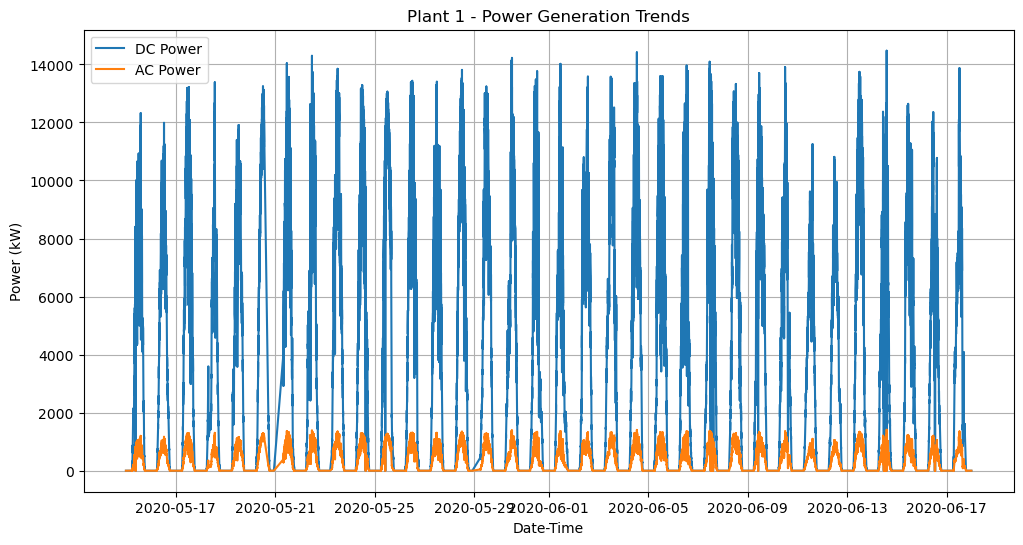

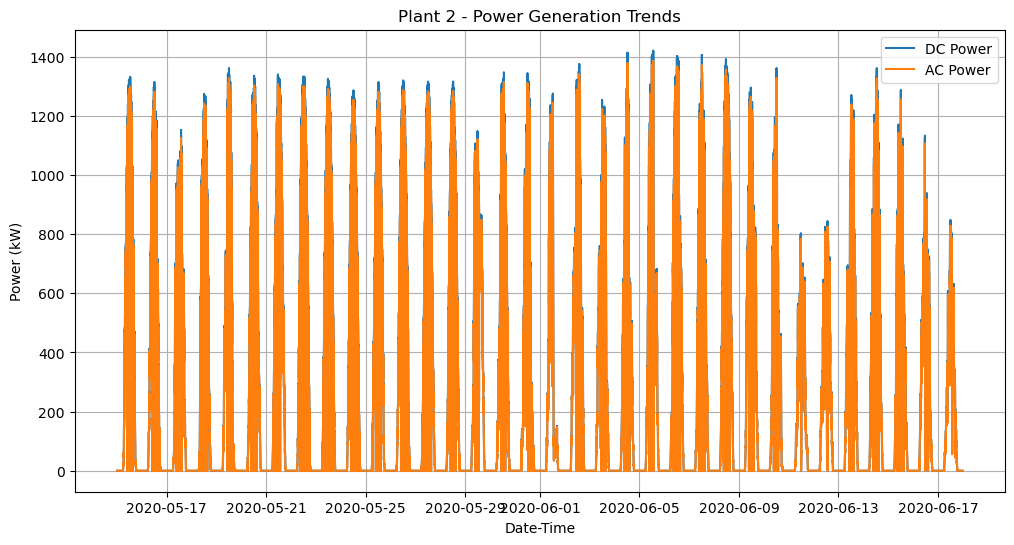

In [13]:
def plot_power_trends(data, plant_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data['DC_POWER'], label='DC Power')
    plt.plot(data['AC_POWER'], label='AC Power')
    plt.title(f'{plant_name} - Power Generation Trends')
    plt.xlabel('Date-Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_power_trends(plant1_data, 'Plant 1')
plot_power_trends(plant2_data, 'Plant 2')

**Plant 1 DC power generation is more compared to AC.**

**Plant 2 has almost equal DC and AC power generation.**

# **Correlation Analysis**

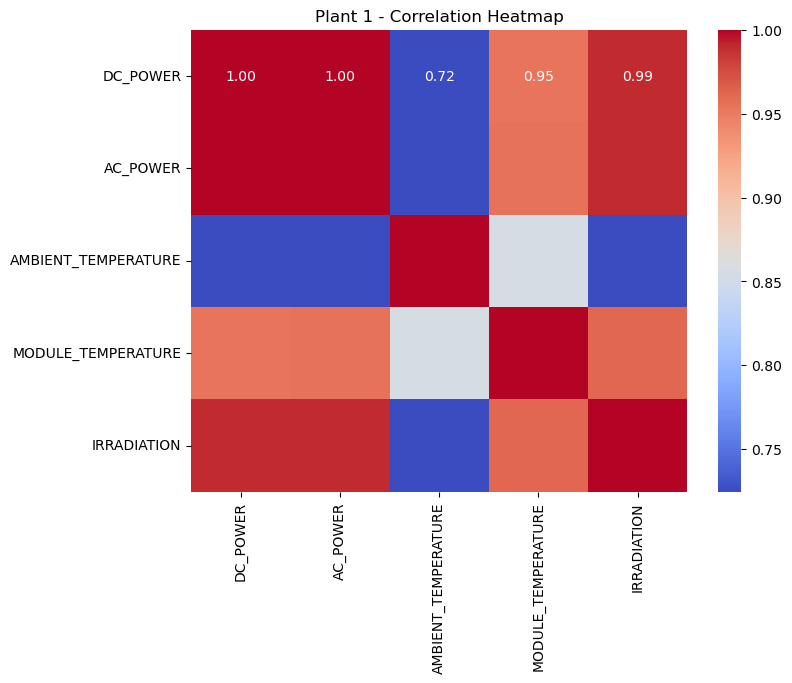

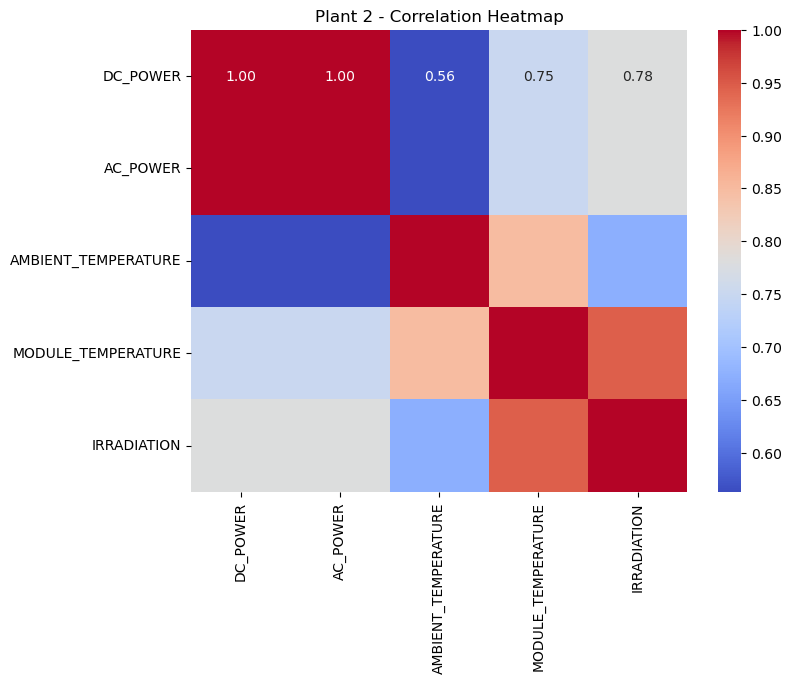

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(plant1_data[['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Plant 1 - Correlation Heatmap')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(plant2_data[['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Plant 2 - Correlation Heatmap')
plt.show()

# **Seasonal Patterns - Rolling Mean (7-day)**

**Since the data is recorded at 15-minute intervals, there are 96 entries per day.
For 7 days: 96 x 7 = 672.**

**The rolling mean smooths out short-term fluctuations (noise) and highlights longer-term seasonal trends.**


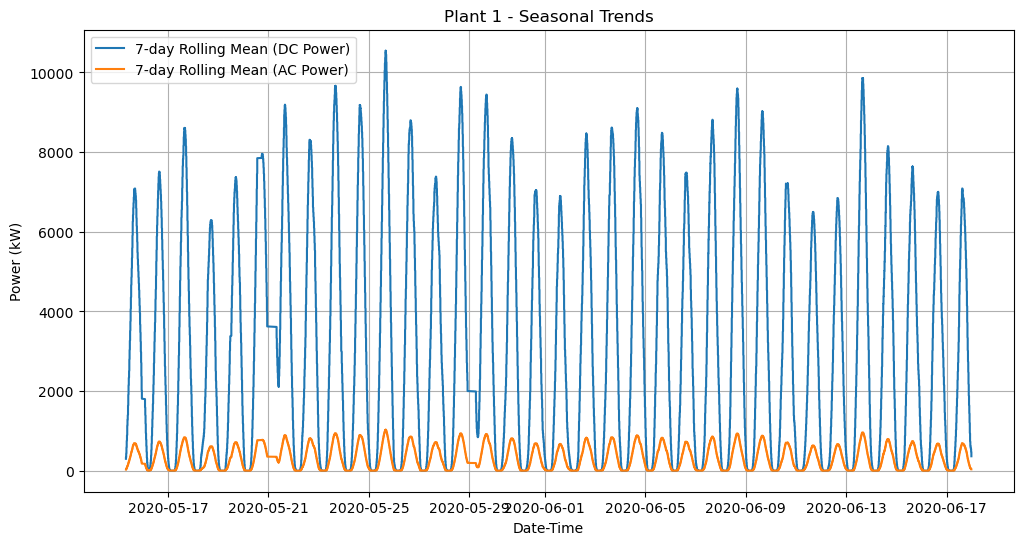

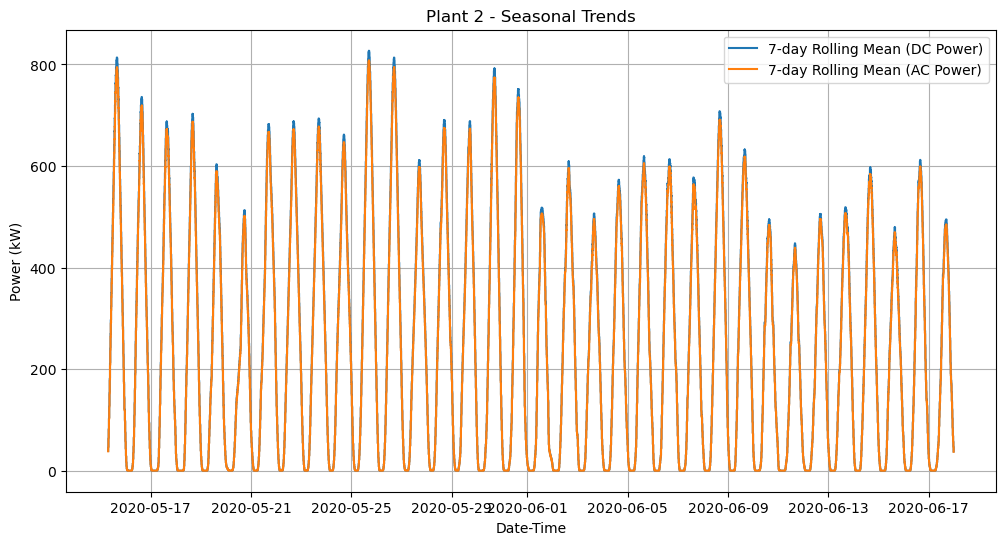

In [15]:
def plot_rolling_mean(data, plant_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data['DC_POWER'].rolling(window=672).mean(), label='7-day Rolling Mean (DC Power)')
    plt.plot(data['AC_POWER'].rolling(window=672).mean(), label='7-day Rolling Mean (AC Power)')
    plt.title(f'{plant_name} - Seasonal Trends')
    plt.xlabel('Date-Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_mean(plant1_data, 'Plant 1')
plot_rolling_mean(plant2_data, 'Plant 2')

# **Distribution Analysis**

c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


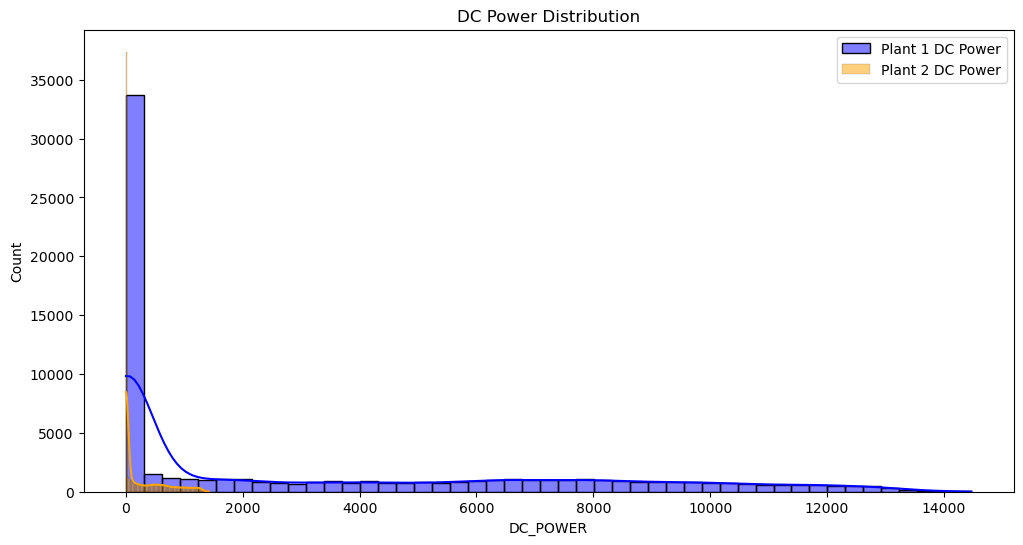

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(plant1_data['DC_POWER'], kde=True, color='blue', label='Plant 1 DC Power')
sns.histplot(plant2_data['DC_POWER'], kde=True, color='orange', label='Plant 2 DC Power')
plt.title('DC Power Distribution')
plt.legend()
plt.show()

**Both Plant 1 (blue) and Plant 2 (orange) show a right-skewed distribution with a sharp peak near zero.
The majority of DC_POWER values are very low, with a long tail extending toward higher values.
Most data points are clustered close to zero, suggesting many instances where power generation was minimal or inactive.**

# **Log Transformation and Distribution Analysis**

**Since the data is heavily skewed, applying a log transformation can stabilize variance and improve visual interpretation. The log transformation helps compress the long tail and reveals underlying patterns in the data. The KDE (Kernel Density Estimation) curve will appear smoother, making peaks and patterns easier to interpret.**

c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


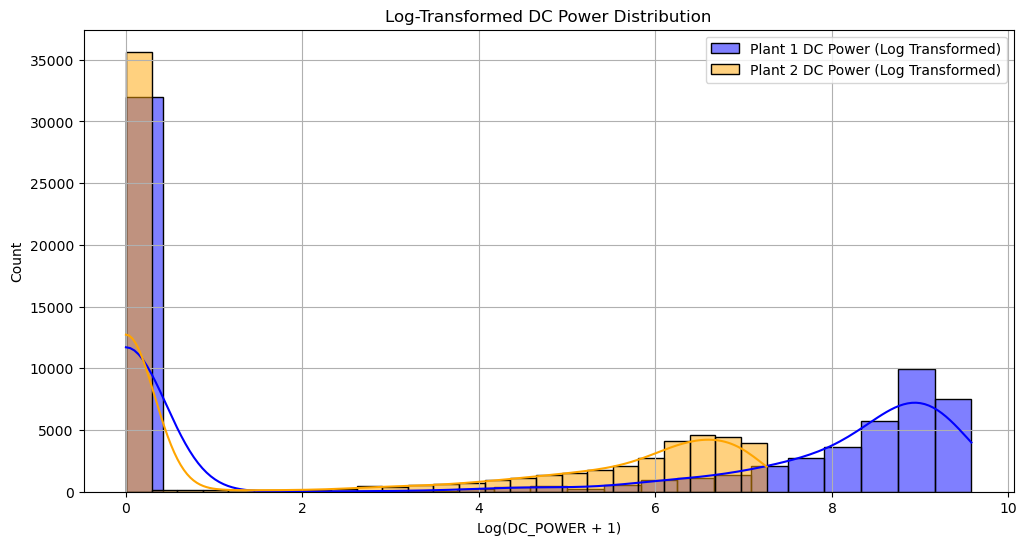

In [17]:
plt.figure(figsize=(12, 6))

# Applying log transformation (Adding 1 to avoid log(0))
sns.histplot(np.log1p(plant1_data['DC_POWER']), kde=True, color='blue', label='Plant 1 DC Power (Log Transformed)')
sns.histplot(np.log1p(plant2_data['DC_POWER']), kde=True, color='orange', label='Plant 2 DC Power (Log Transformed)')

plt.title('Log-Transformed DC Power Distribution')
plt.xlabel('Log(DC_POWER + 1)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

**The large spike near zero suggests a significant number of zero-valued or near-zero DC_POWER values. This might indicate:**

**1. Night-time data (no solar power generation).**

**2. Periods of maintenance or shutdown in the solar plants.**

**Despite the log transformation, the data still retains some skewness.**

**1. Plant 1 exhibits a stronger concentration at higher values post-log transformation.**

**2. Plant 2 has a broader spread of mid-range values, indicating possible variability in energy output.**

# **Daily, Weekly, Monthly DC Power Generation Trend**

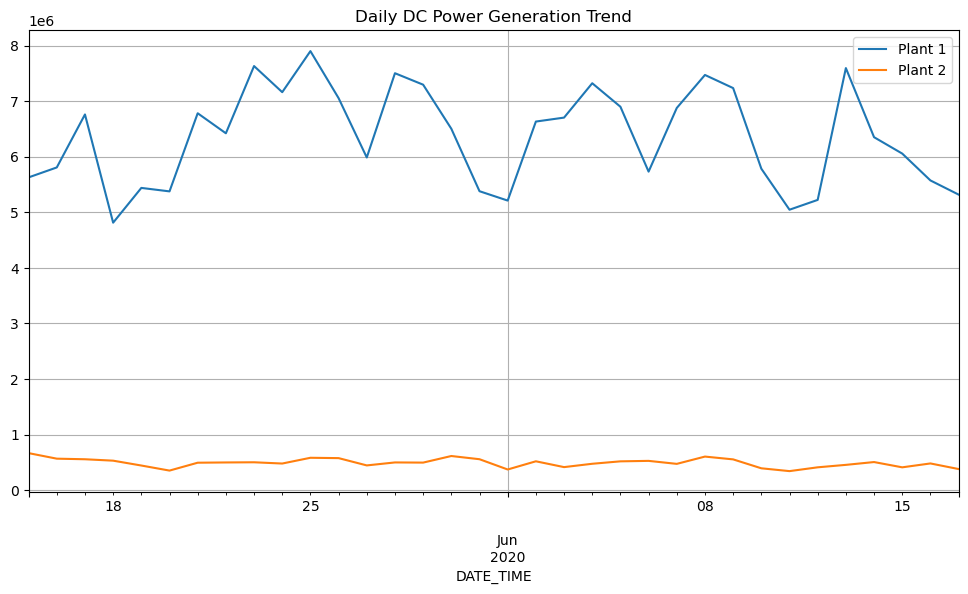

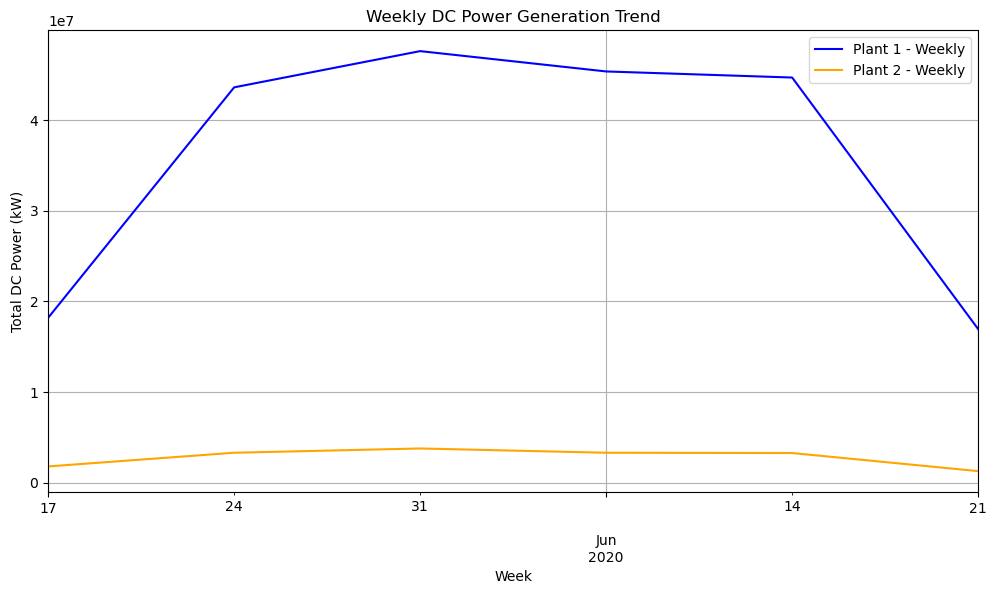

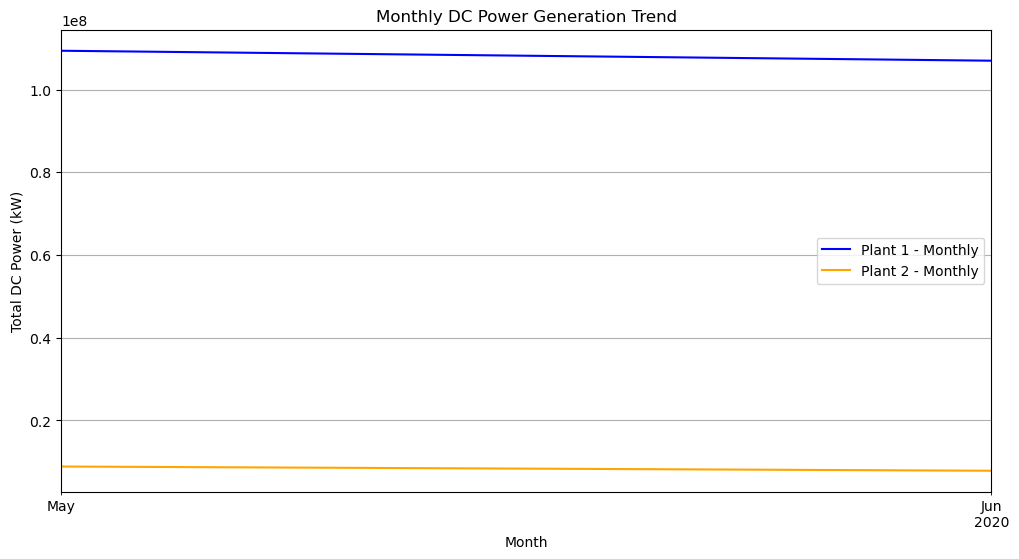

In [18]:
# Daily Aggregation and Visualization
plant1_data['DC_POWER'].resample('D').sum().plot(label='Plant 1', figsize=(12, 6))
plant2_data['DC_POWER'].resample('D').sum().plot(label='Plant 2')
plt.title('Daily DC Power Generation Trend')
plt.legend()
plt.grid(True)
plt.show()

# Weekly Aggregation and Visualization
plt.figure(figsize=(12, 6))
plant1_data['DC_POWER'].resample('W').sum().plot(label='Plant 1 - Weekly', color='blue')
plant2_data['DC_POWER'].resample('W').sum().plot(label='Plant 2 - Weekly', color='orange')
plt.title('Weekly DC Power Generation Trend')
plt.xlabel('Week')
plt.ylabel('Total DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# Monthly Aggregation and Visualization
plt.figure(figsize=(12, 6))
plant1_data['DC_POWER'].resample('M').sum().plot(label='Plant 1 - Monthly', color='blue')
plant2_data['DC_POWER'].resample('M').sum().plot(label='Plant 2 - Monthly', color='orange')
plt.title('Monthly DC Power Generation Trend')
plt.xlabel('Month')
plt.ylabel('Total DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **Ambient Temperature Patterns**

**Ambient Temperature is the natural temperature of a space untouched by artificial heating or cooling. In weather, it is the current air temperature outdoors.**

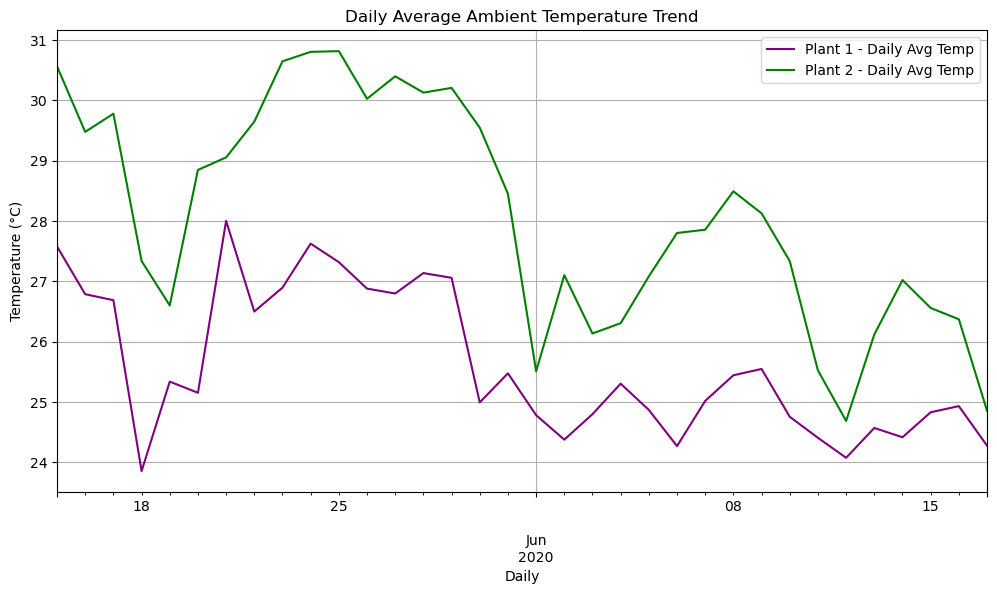

In [19]:
# Daily 
plt.figure(figsize=(12, 6))
plant1_data['AMBIENT_TEMPERATURE'].resample('D').mean().plot(label='Plant 1 - Daily Avg Temp', color='purple')
plant2_data['AMBIENT_TEMPERATURE'].resample('D').mean().plot(label='Plant 2 - Daily Avg Temp', color='green')
plt.title('Daily Average Ambient Temperature Trend')
plt.xlabel('Daily')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

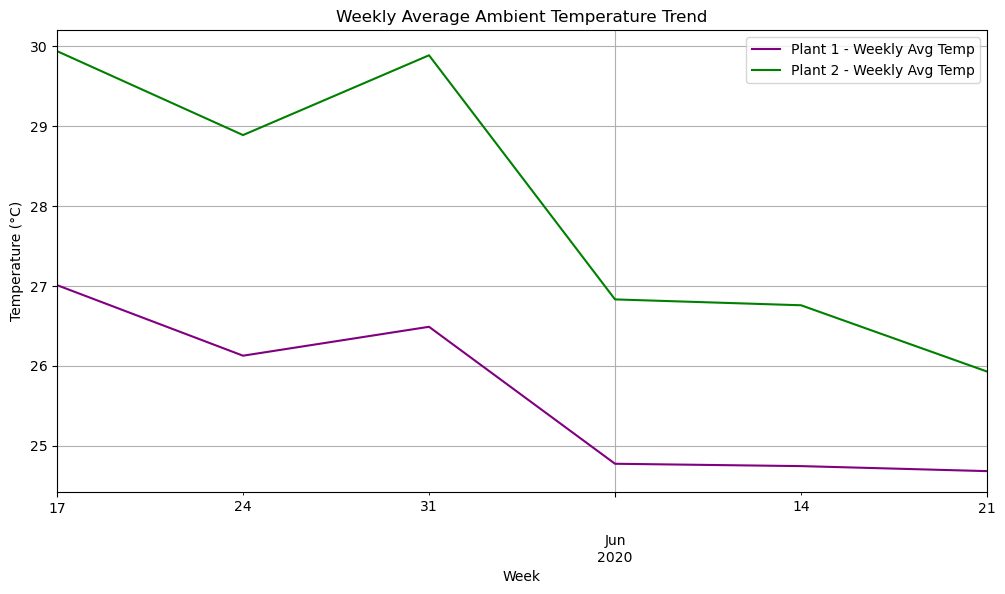

In [20]:
# Weekly
plt.figure(figsize=(12, 6))
plant1_data['AMBIENT_TEMPERATURE'].resample('W').mean().plot(label='Plant 1 - Weekly Avg Temp', color='purple')
plant2_data['AMBIENT_TEMPERATURE'].resample('W').mean().plot(label='Plant 2 - Weekly Avg Temp', color='green')
plt.title('Weekly Average Ambient Temperature Trend')
plt.xlabel('Week')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# **Irradiation Patterns**

**Irradiation in solar energy refers to the amount of solar radiation (energy) received from the sun per unit area over a specific period.**

**It is measured in watts per square meter (W/m²) and indicates the intensity of sunlight hitting a surface.**

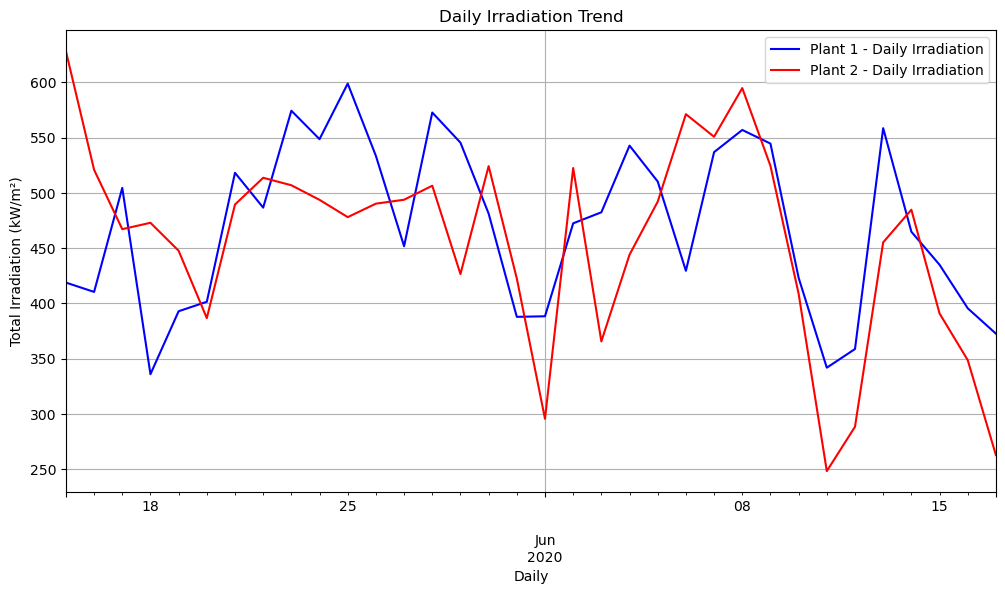

In [21]:
# Daily 
plt.figure(figsize=(12, 6))
plant1_data['IRRADIATION'].resample('D').sum().plot(label='Plant 1 - Daily Irradiation', color='blue')
plant2_data['IRRADIATION'].resample('D').sum().plot(label='Plant 2 - Daily Irradiation', color='red')
plt.title('Daily Irradiation Trend')
plt.xlabel('Daily')
plt.ylabel('Total Irradiation (kW/m²)')
plt.legend()
plt.grid(True)
plt.show()

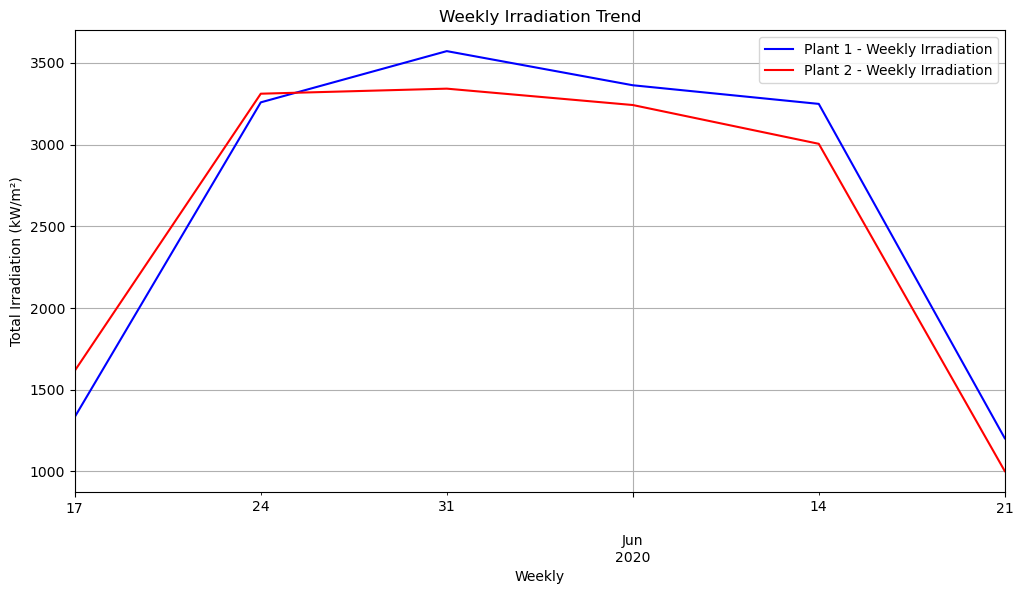

In [22]:
# Weekly
plt.figure(figsize=(12, 6))
plant1_data['IRRADIATION'].resample('W').sum().plot(label='Plant 1 - Weekly Irradiation', color='blue')
plant2_data['IRRADIATION'].resample('W').sum().plot(label='Plant 2 - Weekly Irradiation', color='red')
plt.title('Weekly Irradiation Trend')
plt.xlabel('Weekly')
plt.ylabel('Total Irradiation (kW/m²)')
plt.legend()
plt.grid(True)
plt.show()

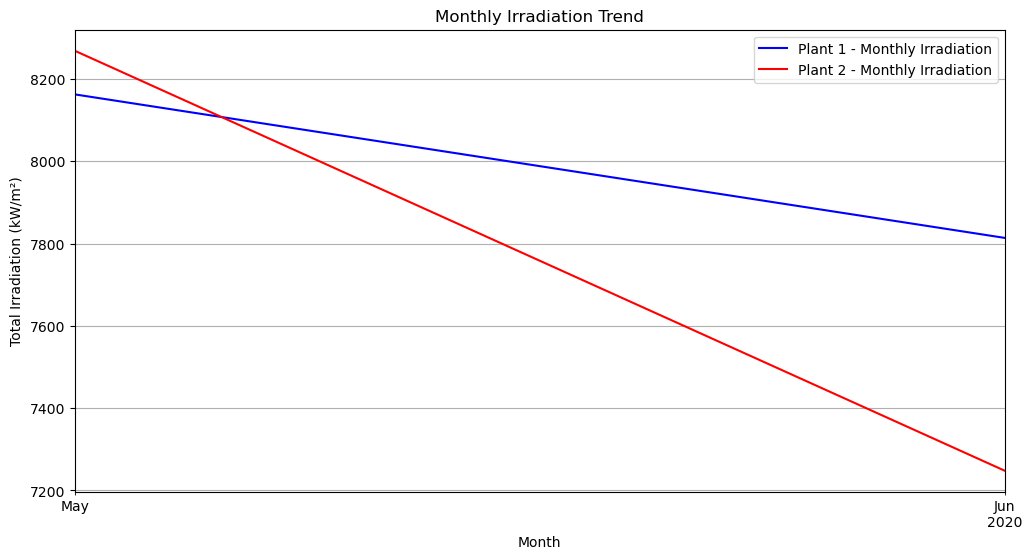

In [23]:
# Monthly
plt.figure(figsize=(12, 6))
plant1_data['IRRADIATION'].resample('M').sum().plot(label='Plant 1 - Monthly Irradiation', color='blue')
plant2_data['IRRADIATION'].resample('M').sum().plot(label='Plant 2 - Monthly Irradiation', color='red')
plt.title('Monthly Irradiation Trend')
plt.xlabel('Month')
plt.ylabel('Total Irradiation (kW/m²)')
plt.legend()
plt.grid(True)
plt.show()

**The Monthly Irradiation Trend shows how the available sunlight energy varies for Plant 1 and Plant 2 across different months, which directly impacts their efficiency and power generation.**

**The blue line (Plant 1) shows a gradual decrease in irradiation, indicating relatively stable conditions with slightly lower sunlight over time.**

**The red line (Plant 2) exhibits a steeper decline, suggesting possibly more intense changes in environmental conditions.**

# **Seasonal Decomposition**

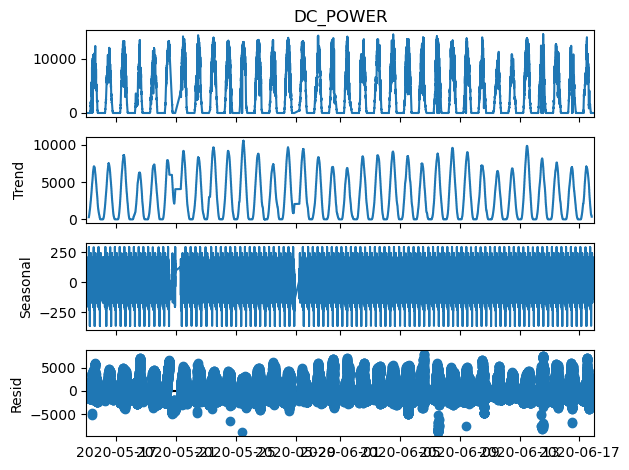

In [ ]:
decomposition = seasonal_decompose(plant1_data['DC_POWER'].dropna(), period=672) # 96*7
decomposition.plot()
plt.show()

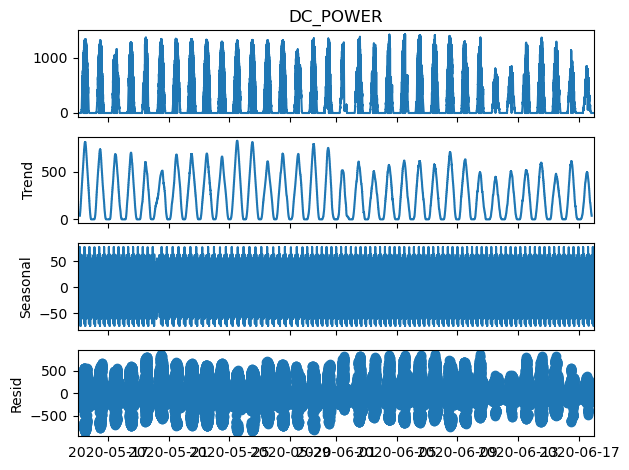

In [ ]:
decomposition = seasonal_decompose(plant2_data['DC_POWER'].dropna(), period=672)
decomposition.plot()
plt.show()

# **Stationarity Test**

In [31]:
def adf_test(series, label):
    if series.nunique() == 1:
        print(f"ADF Test for {label}: Skipped (constant series)\n")
        return
    try:
        result = adfuller(series.dropna().astype(float))  # Ensure numeric conversion
        print(f'ADF Test for {label}')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        if result[1] < 0.05:
            print(f"Result: {label} is stationary\n")
        else:
            print(f"Result: {label} is non-stationary\n")
    except ValueError as e:
        print(f"ADF Test for {label}: Skipped ({e})\n")

def kpss_test(series, label):
    if series.nunique() == 1:
        print(f"KPSS Test for {label}: Skipped (constant series)\n")
        return
    try:
        result = kpss(series.dropna().astype(float), regression='c')
        print(f'KPSS Test for {label}')
        print(f'KPSS Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        if result[1] < 0.05:
            print(f"Result: {label} is non-stationary\n")
        else:
            print(f"Result: {label} is stationary\n")
    except ValueError as e:
        print(f"KPSS Test for {label}: Skipped ({e})\n")

numeric_cols_plant1 = plant1_data.select_dtypes(include='number').columns
numeric_cols_plant2 = plant2_data.select_dtypes(include='number').columns

for col in numeric_cols_plant1:
    adf_test(plant1_data[col], f'Plant 1 - {col}')
    kpss_test(plant1_data[col], f'Plant 1 - {col}')

for col in numeric_cols_plant2:
    adf_test(plant2_data[col], f'Plant 2 - {col}')
    kpss_test(plant2_data[col], f'Plant 2 - {col}')


ADF Test for Plant 1 - PLANT_ID: Skipped (constant series)

KPSS Test for Plant 1 - PLANT_ID: Skipped (constant series)

ADF Test for Plant 1 - DC_POWER
ADF Statistic: -6.3643116908265505
p-value: 2.431055495484042e-08
Result: Plant 1 - DC_POWER is stationary

KPSS Test for Plant 1 - DC_POWER
KPSS Statistic: 0.094683155891957
p-value: 0.1
Result: Plant 1 - DC_POWER is stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 1 - AC_POWER
ADF Statistic: -6.3574962711829155
p-value: 2.5216591516433148e-08
Result: Plant 1 - AC_POWER is stationary

KPSS Test for Plant 1 - AC_POWER
KPSS Statistic: 0.09416255416117054
p-value: 0.1
Result: Plant 1 - AC_POWER is stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 1 - DAILY_YIELD
ADF Statistic: -7.087506072509261
p-value: 4.4985239001523315e-10
Result: Plant 1 - DAILY_YIELD is stationary

KPSS Test for Plant 1 - DAILY_YIELD
KPSS Statistic: 0.049685318431495706
p-value: 0.1
Result: Plant 1 - DAILY_YIELD is stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 1 - TOTAL_YIELD
ADF Statistic: -3.706066002641416
p-value: 0.004028634927831012
Result: Plant 1 - TOTAL_YIELD is stationary

KPSS Test for Plant 1 - TOTAL_YIELD
KPSS Statistic: 57.30990543254583
p-value: 0.01
Result: Plant 1 - TOTAL_YIELD is non-stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 1 - AMBIENT_TEMPERATURE
ADF Statistic: -6.229908192806685
p-value: 4.9826200652852785e-08
Result: Plant 1 - AMBIENT_TEMPERATURE is stationary

KPSS Test for Plant 1 - AMBIENT_TEMPERATURE
KPSS Statistic: 2.5549075817452973
p-value: 0.01
Result: Plant 1 - AMBIENT_TEMPERATURE is non-stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 1 - MODULE_TEMPERATURE
ADF Statistic: -6.285726386710979
p-value: 3.702280374045665e-08
Result: Plant 1 - MODULE_TEMPERATURE is stationary

KPSS Test for Plant 1 - MODULE_TEMPERATURE
KPSS Statistic: 0.5944706611737944
p-value: 0.02313903080238232
Result: Plant 1 - MODULE_TEMPERATURE is non-stationary

ADF Test for Plant 1 - IRRADIATION
ADF Statistic: -6.675276949996662
p-value: 4.481520951525025e-09
Result: Plant 1 - IRRADIATION is stationary

KPSS Test for Plant 1 - IRRADIATION
KPSS Statistic: 0.13607905677003873
p-value: 0.1
Result: Plant 1 - IRRADIATION is stationary

ADF Test for Plant 2 - PLANT_ID: Skipped (constant series)

KPSS Test for Plant 2 - PLANT_ID: Skipped (constant series)



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 2 - DC_POWER
ADF Statistic: -8.026124448679722
p-value: 2.0151858254155008e-12
Result: Plant 2 - DC_POWER is stationary

KPSS Test for Plant 2 - DC_POWER
KPSS Statistic: 0.40190760736875975
p-value: 0.07633292785829321
Result: Plant 2 - DC_POWER is stationary

ADF Test for Plant 2 - AC_POWER
ADF Statistic: -8.032515909314974
p-value: 1.941222121454022e-12
Result: Plant 2 - AC_POWER is stationary

KPSS Test for Plant 2 - AC_POWER
KPSS Statistic: 0.39919704584253135
p-value: 0.0775012733437365
Result: Plant 2 - AC_POWER is stationary

ADF Test for Plant 2 - DAILY_YIELD
ADF Statistic: -7.581624527382925
p-value: 2.672482883465965e-11
Result: Plant 2 - DAILY_YIELD is stationary

KPSS Test for Plant 2 - DAILY_YIELD
KPSS Statistic: 0.07218003270506326
p-value: 0.1
Result: Plant 2 - DAILY_YIELD is stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 2 - TOTAL_YIELD
ADF Statistic: -20.15160910178716
p-value: 0.0
Result: Plant 2 - TOTAL_YIELD is stationary

KPSS Test for Plant 2 - TOTAL_YIELD
KPSS Statistic: 18.511123043816497
p-value: 0.01
Result: Plant 2 - TOTAL_YIELD is non-stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 2 - AMBIENT_TEMPERATURE
ADF Statistic: -5.767751054925743
p-value: 5.482195865029485e-07
Result: Plant 2 - AMBIENT_TEMPERATURE is stationary

KPSS Test for Plant 2 - AMBIENT_TEMPERATURE
KPSS Statistic: 4.7530817463076955
p-value: 0.01
Result: Plant 2 - AMBIENT_TEMPERATURE is non-stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 2 - MODULE_TEMPERATURE
ADF Statistic: -6.196571575626782
p-value: 5.9454479251360344e-08
Result: Plant 2 - MODULE_TEMPERATURE is stationary

KPSS Test for Plant 2 - MODULE_TEMPERATURE
KPSS Statistic: 1.5312835407477312
p-value: 0.01
Result: Plant 2 - MODULE_TEMPERATURE is non-stationary



C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3281370579.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna().astype(float), regression='c')


ADF Test for Plant 2 - IRRADIATION
ADF Statistic: -6.345190615642468
p-value: 2.6937432505177716e-08
Result: Plant 2 - IRRADIATION is stationary

KPSS Test for Plant 2 - IRRADIATION
KPSS Statistic: 0.48642899761428693
p-value: 0.04472319873552097
Result: Plant 2 - IRRADIATION is non-stationary



In [ ]:
# Function to test stationarity
def test_stationarity(series, column_name):
    print(f"\n{column_name}")
    adf_result = adfuller(series.dropna())
    kpss_result = kpss(series.dropna(), regression='c')

    print(f"ADF Statistic: {adf_result[0]} | p-value: {adf_result[1]} | Result: {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'}")
    print(f"KPSS Statistic: {kpss_result[0]} | p-value: {kpss_result[1]} | Result: {'Non-stationary' if kpss_result[1] < 0.05 else 'Stationary'}")


# Columns to differencing
ambiguous_cols = ['TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']

# Differencing for Plant 1
print("** Plant 1 Results **")
for col in ambiguous_cols:
    plant1_data[f'{col}_diff'] = plant1_data[col].diff()
    test_stationarity(plant1_data[f'{col}_diff'], f'Plant 1 - {col}_diff')

# Differencing for Plant 2
print("\n** Plant 2 Results **")
for col in ambiguous_cols:
    plant2_data[f'{col}_diff'] = plant2_data[col].diff()
    test_stationarity(plant2_data[f'{col}_diff'], f'Plant 2 - {col}_diff')

** Plant 1 Results **

Plant 1 - TOTAL_YIELD_diff


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF Statistic: -41.52089460459212 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.003260168925230746 | p-value: 0.1 | Result: Stationary

Plant 1 - AMBIENT_TEMPERATURE_diff


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF Statistic: -26.117421462472155 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.02858360163308032 | p-value: 0.1 | Result: Stationary

Plant 1 - MODULE_TEMPERATURE_diff


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF Statistic: -49.03605298179884 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.013259564037114775 | p-value: 0.1 | Result: Stationary

** Plant 2 Results **

Plant 2 - TOTAL_YIELD_diff


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF Statistic: -45.90423012761084 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.00038210868001087474 | p-value: 0.1 | Result: Stationary

Plant 2 - AMBIENT_TEMPERATURE_diff


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF Statistic: -25.044301842823234 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.034600401335453605 | p-value: 0.1 | Result: Stationary

Plant 2 - MODULE_TEMPERATURE_diff
ADF Statistic: -31.11659929062582 | p-value: 0.0 | Result: Stationary
KPSS Statistic: 0.016317823863453998 | p-value: 0.1 | Result: Stationary


C:\Users\ankit\AppData\Local\Temp\ipykernel_5964\3614523128.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


# **----------------------------Plant 1----------------------------**

# **ACF & PACF Plot**

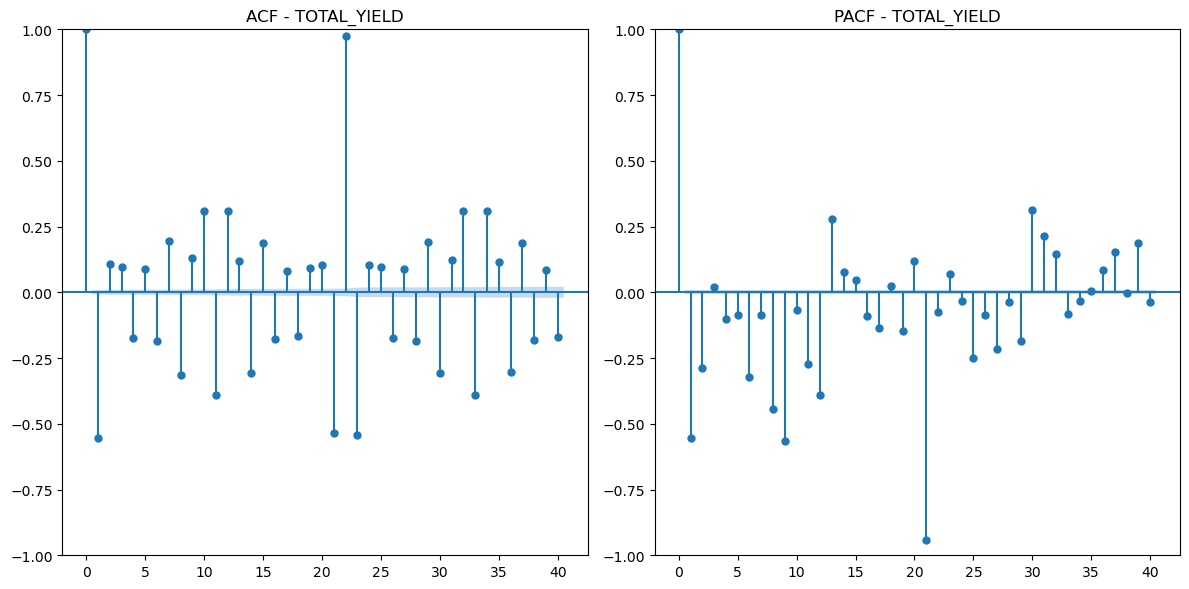

In [33]:
# ACF and PACF for Plant 1's TOTAL_YIELD
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(plant1_data['TOTAL_YIELD_diff'].dropna(), lags=40, ax=plt.gca(), title='ACF - TOTAL_YIELD')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(plant1_data['TOTAL_YIELD_diff'].dropna(), lags=40, ax=plt.gca(), title='PACF - TOTAL_YIELD')

plt.tight_layout()
plt.show()

In [35]:
# Ensure data is sorted by timestamp
plant1_data = plant1_data.sort_index()
plant2_data = plant2_data.sort_index()

# Calculate split index
train_size = int(len(plant1_data) * 0.8)

# Temporal split for Plant 1
train_plant1 = plant1_data.iloc[:train_size]
test_plant1 = plant1_data.iloc[train_size:]

# Temporal split for Plant 2
train_plant2 = plant2_data.iloc[:train_size]
test_plant2 = plant2_data.iloc[train_size:]

print(f"Plant 1 - Train: {train_plant1.index[0]} to {train_plant1.index[-1]}")
print(f"Plant 1 - Test: {test_plant1.index[0]} to {test_plant1.index[-1]}")
print(f"Plant 2 - Train: {train_plant2.index[0]} to {train_plant2.index[-1]}")
print(f"Plant 2 - Test: {test_plant2.index[0]} to {test_plant2.index[-1]}")

Plant 1 - Train: 2020-05-15 00:00:00 to 2020-06-11 11:00:00
Plant 1 - Test: 2020-06-11 11:00:00 to 2020-06-17 23:45:00
Plant 2 - Train: 2020-05-15 00:00:00 to 2020-06-11 23:45:00
Plant 2 - Test: 2020-06-11 23:45:00 to 2020-06-17 23:45:00


# **ARIMA**

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\P

ARIMA - Plant 1 (No Exogenous Variables)
MSE: 3762780.0366
RMSE: 1939.7887
MAE: 1651.9638
R-squared: -0.1917


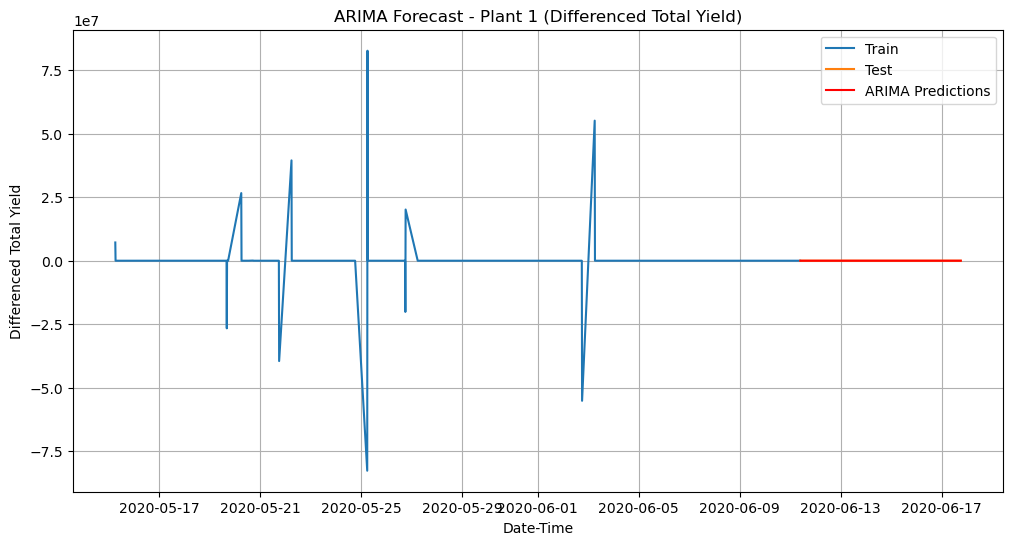

In [60]:
# Check and handle duplicate indices
duplicate_indices = plant1_data.index.duplicated(keep=False)
if duplicate_indices.any():
    print("Duplicate indices found. Aggregating data by timestamp...")
    plant1_data = plant1_data.groupby(plant1_data.index).agg({
        'TOTAL_YIELD': 'sum',
        'DC_POWER': 'sum',
        'AC_POWER': 'sum',
        'IRRADIATION': 'mean',
        'AMBIENT_TEMPERATURE': 'mean',
        'MODULE_TEMPERATURE': 'mean'
    }).reset_index().set_index('DATE_TIME')

# Filter out nighttime data
plant1_data_day = plant1_data[plant1_data['IRRADIATION'] > 0.01].copy()

# Prepare differenced data
plant1_data_day['TOTAL_YIELD_diff'] = plant1_data_day['TOTAL_YIELD'].diff()

# Drop NA values (including the first row due to differencing)
data = plant1_data_day[['TOTAL_YIELD_diff']].dropna()

# Temporal split (80-20)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Fit ARIMA model (without exogenous variables)
model = ARIMA(
    train['TOTAL_YIELD_diff'],
    order=(1, 1, 0)  # (p, d, q) - initial guess
)
model_fit = model.fit()

# Forecast
predictions = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test['TOTAL_YIELD_diff'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTAL_YIELD_diff'], predictions)
r2 = r2_score(test['TOTAL_YIELD_diff'], predictions)

print(f'ARIMA - Plant 1 (No Exogenous Variables)')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['TOTAL_YIELD_diff'], label='Train')
plt.plot(test.index, test['TOTAL_YIELD_diff'], label='Test')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Forecast - Plant 1 (Differenced Total Yield)')
plt.xlabel('Date-Time')
plt.ylabel('Differenced Total Yield')
plt.legend()
plt.grid(True)
plt.show()

# **SARIMA**

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

SARIMA - Plant 1
MSE: 45526177242882.2969
RMSE: 6747308.8889
MAE: 5880126.9507
R-squared: -14418873.8454


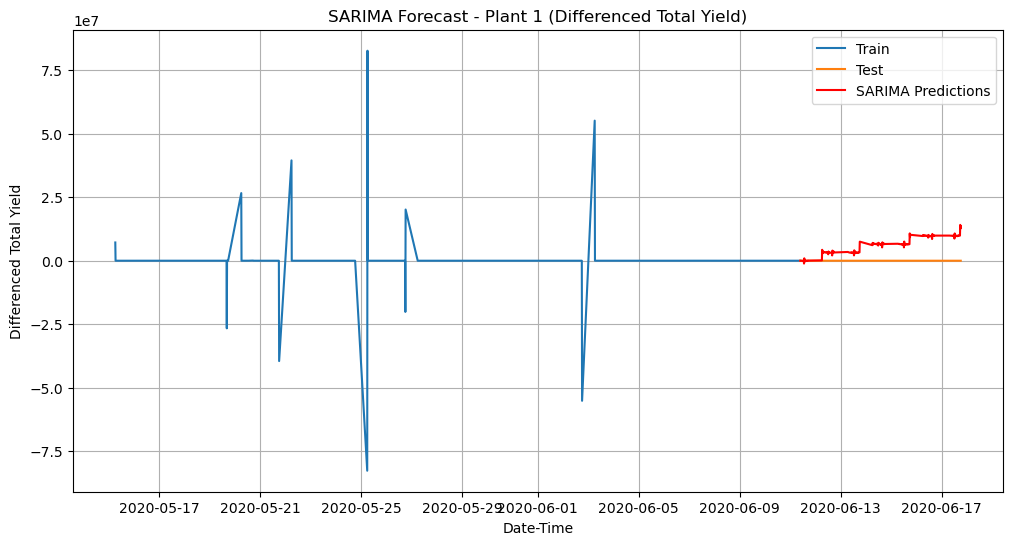

In [ ]:
# Check and handle duplicate indices (from Step 1)
duplicate_indices = plant1_data.index.duplicated(keep=False)
if duplicate_indices.any():
    plant1_data = plant1_data.groupby(plant1_data.index).agg({
        'TOTAL_YIELD': 'sum',
        'DC_POWER': 'sum',
        'AC_POWER': 'sum',
        'IRRADIATION': 'mean',
        'AMBIENT_TEMPERATURE': 'mean',
        'MODULE_TEMPERATURE': 'mean'
    }).reset_index().set_index('DATE_TIME')

# Filter out nighttime data
plant1_data_day = plant1_data[plant1_data['IRRADIATION'] > 0.01].copy()

# Prepare differenced data and exogenous variables
plant1_data_day['TOTAL_YIELD_diff'] = plant1_data_day['TOTAL_YIELD'].diff()
exog_vars = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']

# Drop NA values (including the first row due to differencing)
data = plant1_data_day[['TOTAL_YIELD_diff'] + exog_vars].dropna()

# Temporal split (80-20)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Fit SARIMA with exogenous variables
model = SARIMAX(
    train['TOTAL_YIELD_diff'],
    exog=train[exog_vars],
    order=(1, 1, 0),  # Non-seasonal (p, d, q)
    seasonal_order=(1, 1, 1, 96),  # Seasonal (P, D, Q, s) - s=96 for daily (15-min intervals)
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)

# Forecast
predictions = model_fit.forecast(
    steps=len(test),
    exog=test[exog_vars]
)

# Evaluate
mse = mean_squared_error(test['TOTAL_YIELD_diff'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTAL_YIELD_diff'], predictions)
r2 = r2_score(test['TOTAL_YIELD_diff'], predictions)

print(f'SARIMA - Plant 1')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['TOTAL_YIELD_diff'], label='Train')
plt.plot(test.index, test['TOTAL_YIELD_diff'], label='Test')
plt.plot(test.index, predictions, label='SARIMA Predictions', color='red')
plt.title('SARIMA Forecast - Plant 1 (Differenced Total Yield)')
plt.xlabel('Date-Time')
plt.ylabel('Differenced Total Yield')
plt.legend()
plt.grid(True)
plt.show()

# **XGBoost**

XGBoost - Plant 1
MSE: 265007.9028
RMSE: 514.7892
MAE: 148.9468
R-squared: 0.9811


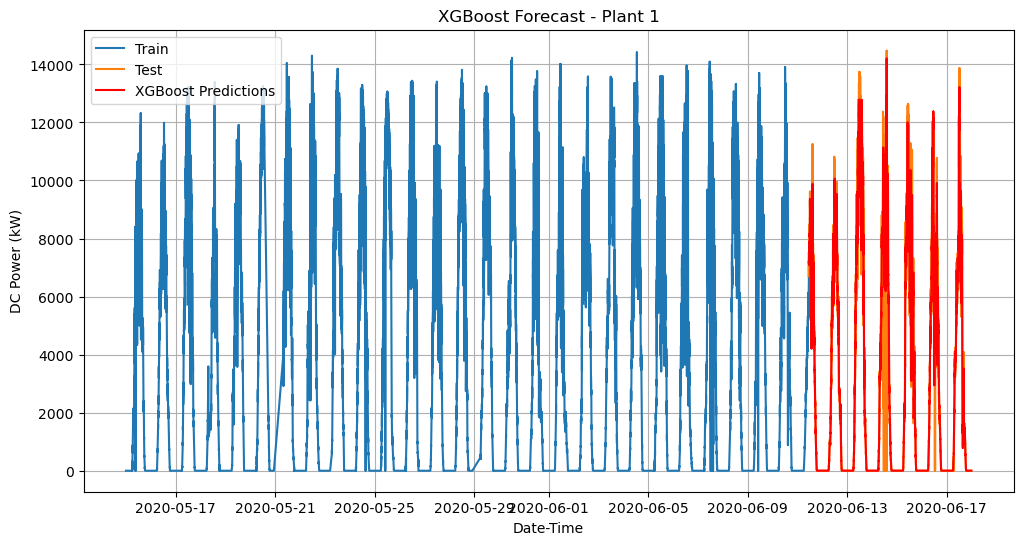

In [ ]:
# Prepare features
plant1_data['hour'] = plant1_data.index.hour
plant1_data['day'] = plant1_data.index.dayofweek
plant1_data['lag1'] = plant1_data['DC_POWER'].shift(1)
plant1_data['lag2'] = plant1_data['DC_POWER'].shift(2)
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'hour', 'day', 'lag1', 'lag2']
target = 'DC_POWER'

# Drop NA values
data = plant1_data[features + [target]].dropna()

# Temporal split
train_size = int(len(data) * 0.8)
X_train = data[features].iloc[:train_size]
y_train = data[target].iloc[:train_size]
X_test = data[features].iloc[train_size:]
y_test = data[target].iloc[train_size:]

# Train XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'XGBoost - Plant 1')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predictions, label='XGBoost Predictions', color='red')
plt.title('XGBoost Forecast - Plant 1')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **Prophet**

13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Plant 1
MSE: 297647.0726
RMSE: 545.5704
MAE: 222.4205
R-squared: 0.9788


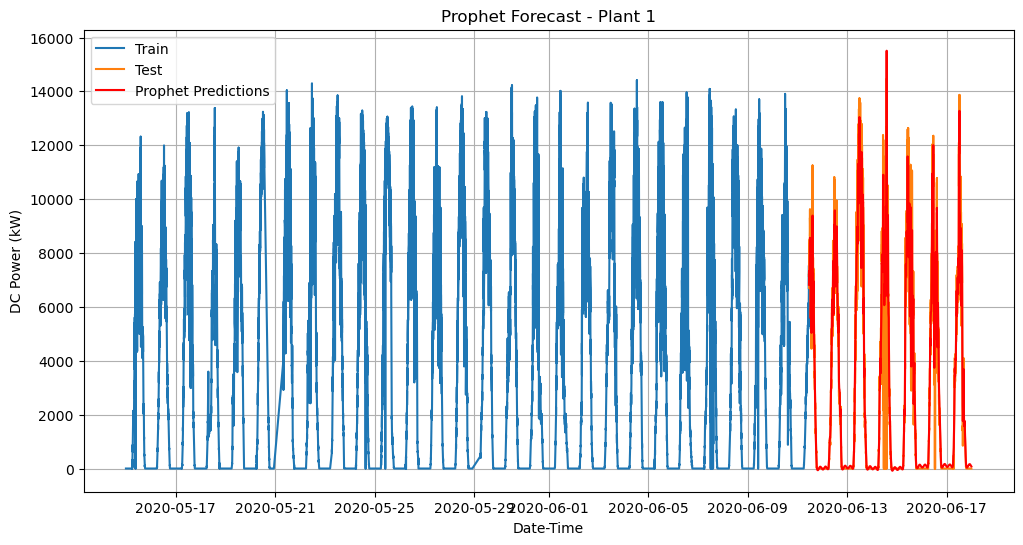

In [ ]:
# Prepare data for Prophet
df_prophet = plant1_data[['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE']].reset_index()
df_prophet = df_prophet.rename(columns={'DATE_TIME': 'ds', 'DC_POWER': 'y'})
df_prophet = df_prophet.dropna()

# Temporal split
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

# Fit Prophet
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.add_regressor('IRRADIATION')
model.add_regressor('AMBIENT_TEMPERATURE')
model.fit(train_prophet[['ds', 'y', 'IRRADIATION', 'AMBIENT_TEMPERATURE']])

# Create future dataframe
future = test_prophet[['ds', 'IRRADIATION', 'AMBIENT_TEMPERATURE']]
forecast = model.predict(future)

# Evaluate
predictions = forecast['yhat']
y_test = test_prophet['y']
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Prophet - Plant 1')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test')
plt.plot(test_prophet['ds'], predictions, label='Prophet Predictions', color='red')
plt.title('Prophet Forecast - Plant 1')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **LSTM**

Epoch 1/20
1546/1546 [==============================] - 148s 92ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 2/20
1546/1546 [==============================] - 129s 83ms/step - loss: 0.0018 - val_loss: 8.1314e-04
Epoch 3/20
1546/1546 [==============================] - 130s 84ms/step - loss: 0.0018 - val_loss: 7.9920e-04
Epoch 4/20
1546/1546 [==============================] - 129s 84ms/step - loss: 0.0017 - val_loss: 8.1229e-04
Epoch 5/20
1546/1546 [==============================] - 128s 83ms/step - loss: 0.0017 - val_loss: 7.8386e-04
Epoch 6/20
1546/1546 [==============================] - 113s 73ms/step - loss: 0.0016 - val_loss: 9.5454e-04
Epoch 7/20
1546/1546 [==============================] - 112s 72ms/step - loss: 0.0016 - val_loss: 7.2628e-04
Epoch 8/20
1546/1546 [==============================] - 114s 74ms/step - loss: 0.0016 - val_loss: 8.0623e-04
Epoch 9/20
1546/1546 [==============================] - 113s 73ms/step - loss: 0.0016 - val_loss: 9.2905e-04
Epoch 10/20
1546/1546 [

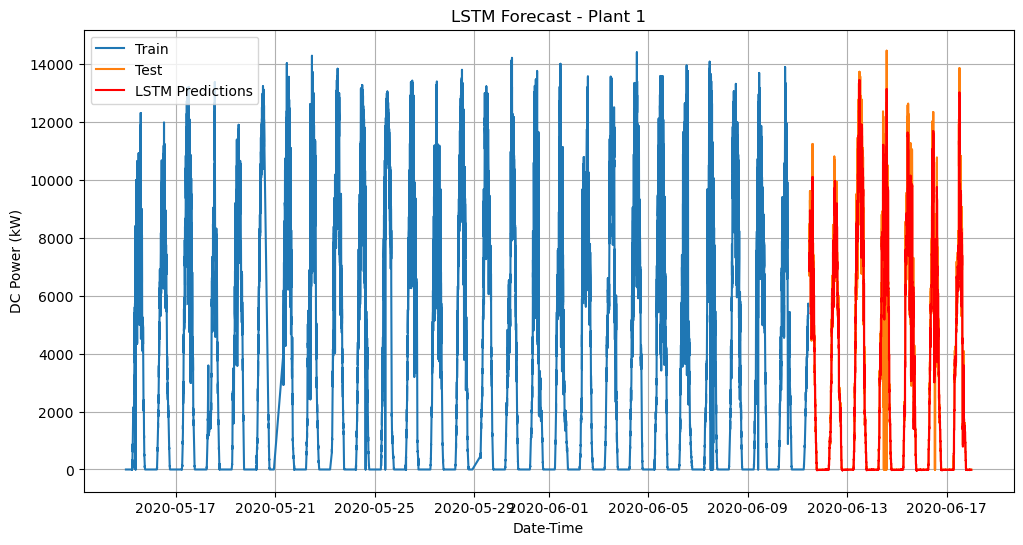

In [ ]:
# Prepare data
data = plant1_data[['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict DC_POWER
    return np.array(X), np.array(y)

seq_length = 96  # 1 day
X, y = create_sequences(scaled_data, seq_length)

# Temporal split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Predict
predictions = model.predict(X_test)

# Inverse transform predictions
predictions_full = np.zeros((len(predictions), scaled_data.shape[1]))
predictions_full[:, 0] = predictions.flatten()
predictions_full = scaler.inverse_transform(predictions_full)
y_test_full = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_full[:, 0] = y_test
y_test_full = scaler.inverse_transform(y_test_full)

# Evaluate
mse = mean_squared_error(y_test_full[:, 0], predictions_full[:, 0])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_full[:, 0], predictions_full[:, 0])
r2 = r2_score(y_test_full[:, 0], predictions_full[:, 0])

print(f'LSTM - Plant 1')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot (approximate index for plotting)
test_indices = data.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], data['DC_POWER'][:train_size], label='Train')
plt.plot(test_indices, y_test_full[:, 0], label='Test')
plt.plot(test_indices, predictions_full[:, 0], label='LSTM Predictions', color='red')
plt.title('LSTM Forecast - Plant 1')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **Anomaly Detection**

Anomalies detected in Plant 1:
                        DC_POWER  IRRADIATION  AMBIENT_TEMPERATURE  \
DATE_TIME                                                            
2020-05-15 14:15:00  12194.71429     0.893661            34.130770   
2020-05-15 14:15:00  12158.28571     0.893661            34.130770   
2020-05-15 14:15:00  12040.57143     0.893661            34.130770   
2020-05-15 14:15:00  11913.71429     0.893661            34.130770   
2020-05-15 14:15:00  11996.87500     0.893661            34.130770   
...                          ...          ...                  ...   
2020-06-17 12:15:00  13627.42857     1.031230            28.649095   
2020-06-17 12:15:00  13692.85714     1.031230            28.649095   
2020-06-17 12:15:00  13287.85714     1.031230            28.649095   
2020-06-17 12:15:00  13586.50000     1.031230            28.649095   
2020-06-17 12:15:00  13301.42857     1.031230            28.649095   

                     MODULE_TEMPERATURE  
DATE_TIME       

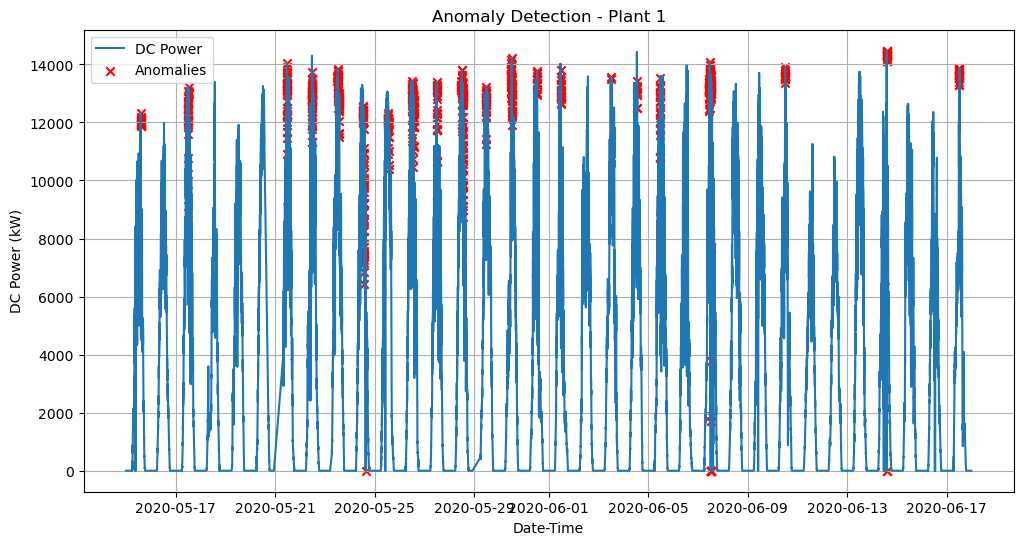

In [ ]:
# Prepare data
features = ['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
X = plant1_data[features].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
plant1_data['anomaly'] = iso_forest.fit_predict(X)

# Extract anomalies
anomalies = plant1_data[plant1_data['anomaly'] == -1]
print(f"Anomalies detected in Plant 1:\n{anomalies[features]}")

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(plant1_data.index, plant1_data['DC_POWER'], label='DC Power')
plt.scatter(anomalies.index, anomalies['DC_POWER'], color='red', label='Anomalies', marker='x')
plt.title('Anomaly Detection - Plant 1')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **----------------------------Plant 2----------------------------**

# **ACF & PACF Plot**

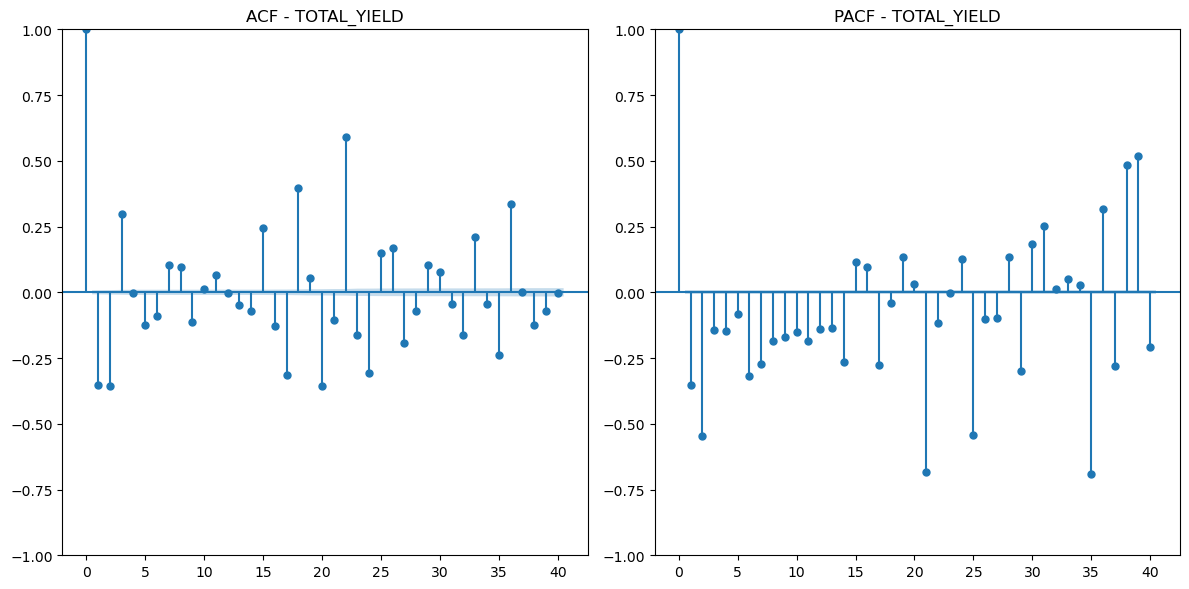

In [58]:
# ACF and PACF for Plant 2's TOTAL_YIELD
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(plant2_data['TOTAL_YIELD_diff'].dropna(), lags=40, ax=plt.gca(), title='ACF - TOTAL_YIELD')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(plant2_data['TOTAL_YIELD_diff'].dropna(), lags=40, ax=plt.gca(), title='PACF - TOTAL_YIELD')

plt.tight_layout()
plt.show()

# **ARIMA**

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\P

ARIMA - Plant 2 (No Exogenous Variables)
MSE: 3454289797512957952.0000
RMSE: 1858571978.0286
MAE: 409362584.6086
R-squared: -0.0000


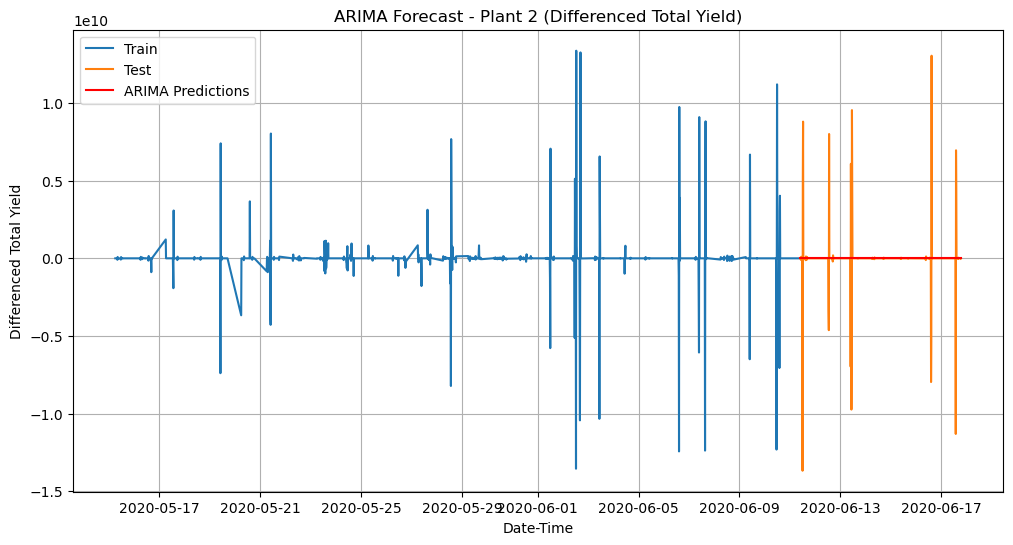

In [67]:
# Check and handle duplicate indices
duplicate_indices = plant2_data.index.duplicated(keep=False)
if duplicate_indices.any():
    print("Duplicate indices found. Aggregating data by timestamp...")
    plant2_data = plant2_data.groupby(plant2_data.index).agg({
        'TOTAL_YIELD': 'sum',
        'DC_POWER': 'sum',
        'AC_POWER': 'sum',
        'IRRADIATION': 'mean',
        'AMBIENT_TEMPERATURE': 'mean',
        'MODULE_TEMPERATURE': 'mean'
    }).reset_index().set_index('DATE_TIME')

# Filter out nighttime data
plant2_data_day = plant2_data[plant2_data['IRRADIATION'] > 0.01].copy()

# Prepare differenced data
plant2_data_day['TOTAL_YIELD_diff'] = plant2_data_day['TOTAL_YIELD'].diff()

# Drop NA values (including the first row due to differencing)
data = plant2_data_day[['TOTAL_YIELD_diff']].dropna()

# Temporal split (80-20)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Fit ARIMA model (without exogenous variables)
model = ARIMA(
    train['TOTAL_YIELD_diff'],
    order=(1, 1, 0)  # (p, d, q) - initial guess
)
model_fit = model.fit()

# Forecast
predictions = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test['TOTAL_YIELD_diff'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTAL_YIELD_diff'], predictions)
r2 = r2_score(test['TOTAL_YIELD_diff'], predictions)

print(f'ARIMA - Plant 2 (No Exogenous Variables)')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['TOTAL_YIELD_diff'], label='Train')
plt.plot(test.index, test['TOTAL_YIELD_diff'], label='Test')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Forecast - Plant 2 (Differenced Total Yield)')
plt.xlabel('Date-Time')
plt.ylabel('Differenced Total Yield')
plt.legend()
plt.grid(True)
plt.show()

# **SARIMA**

c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

SARIMA - Plant 2
MSE: 3810726438028280832.0000
RMSE: 1952108203.4632
MAE: 771998998.6933
R-squared: -0.1032


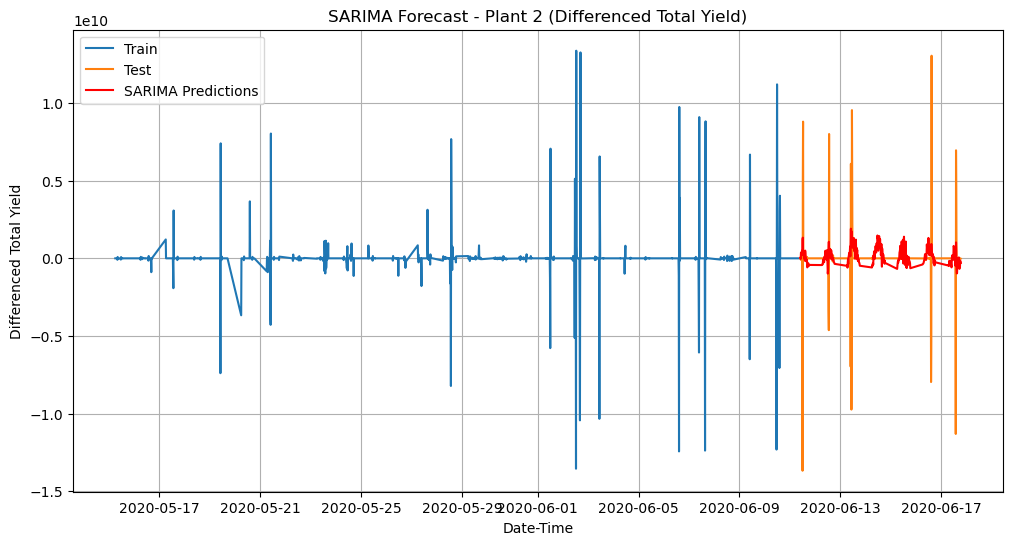

In [68]:
# Check and handle duplicate indices (from Step 1)
duplicate_indices = plant2_data.index.duplicated(keep=False)
if duplicate_indices.any():
    plant2_data = plant2_data.groupby(plant2_data.index).agg({
        'TOTAL_YIELD': 'sum',
        'DC_POWER': 'sum',
        'AC_POWER': 'sum',
        'IRRADIATION': 'mean',
        'AMBIENT_TEMPERATURE': 'mean',
        'MODULE_TEMPERATURE': 'mean'
    }).reset_index().set_index('DATE_TIME')

# Filter out nighttime data
plant2_data_day = plant2_data[plant2_data['IRRADIATION'] > 0.01].copy()

# Prepare differenced data and exogenous variables
plant2_data_day['TOTAL_YIELD_diff'] = plant2_data_day['TOTAL_YIELD'].diff()
exog_vars = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']

# Drop NA values (including the first row due to differencing)
data = plant2_data_day[['TOTAL_YIELD_diff'] + exog_vars].dropna()

# Temporal split (80-20)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Fit SARIMA with exogenous variables
model = SARIMAX(
    train['TOTAL_YIELD_diff'],
    exog=train[exog_vars],
    order=(1, 1, 0),  # Non-seasonal (p, d, q)
    seasonal_order=(1, 1, 1, 96),  # Seasonal (P, D, Q, s) - s=96 for daily (15-min intervals)
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)

# Forecast
predictions = model_fit.forecast(
    steps=len(test),
    exog=test[exog_vars]
)

# Evaluate
mse = mean_squared_error(test['TOTAL_YIELD_diff'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTAL_YIELD_diff'], predictions)
r2 = r2_score(test['TOTAL_YIELD_diff'], predictions)

print(f'SARIMA - Plant 2')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['TOTAL_YIELD_diff'], label='Train')
plt.plot(test.index, test['TOTAL_YIELD_diff'], label='Test')
plt.plot(test.index, predictions, label='SARIMA Predictions', color='red')
plt.title('SARIMA Forecast - Plant 2 (Differenced Total Yield)')
plt.xlabel('Date-Time')
plt.ylabel('Differenced Total Yield')
plt.legend()
plt.grid(True)
plt.show()

# **XGBoost**

XGBoost - Plant 2
MSE: 2998744.9245
RMSE: 1731.6885
MAE: 694.5910
R-squared: 0.9055


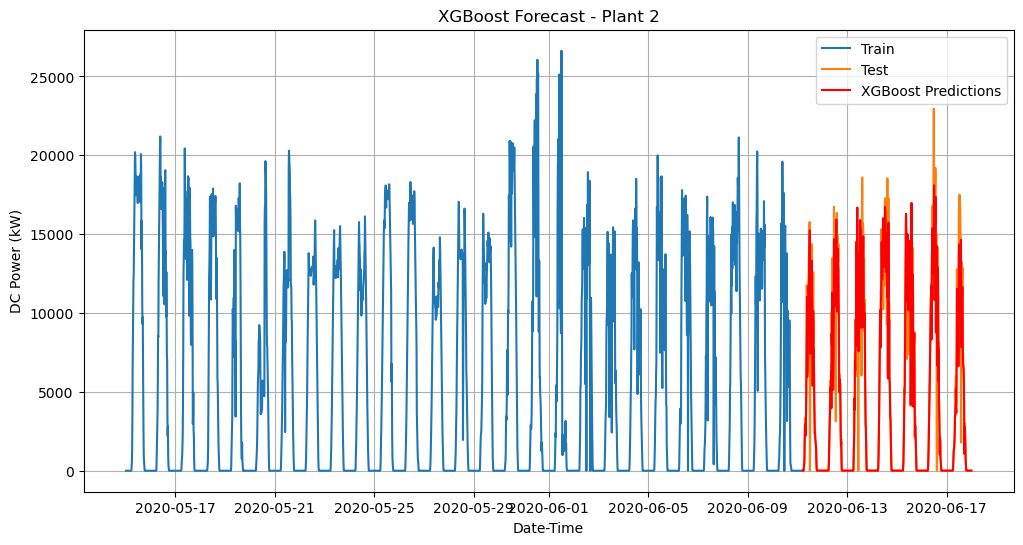

In [69]:
# Prepare features
plant2_data['hour'] = plant2_data.index.hour
plant2_data['day'] = plant2_data.index.dayofweek
plant2_data['lag1'] = plant2_data['DC_POWER'].shift(1)
plant2_data['lag2'] = plant2_data['DC_POWER'].shift(2)
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'hour', 'day', 'lag1', 'lag2']
target = 'DC_POWER'

# Drop NA values
data = plant2_data[features + [target]].dropna()

# Temporal split
train_size = int(len(data) * 0.8)
X_train = data[features].iloc[:train_size]
y_train = data[target].iloc[:train_size]
X_test = data[features].iloc[train_size:]
y_test = data[target].iloc[train_size:]

# Train XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'XGBoost - Plant 2')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predictions, label='XGBoost Predictions', color='red')
plt.title('XGBoost Forecast - Plant 2')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **Prophet**

21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Plant 2
MSE: 6571406.3099
RMSE: 2563.4754
MAE: 1629.3521
R-squared: 0.7930


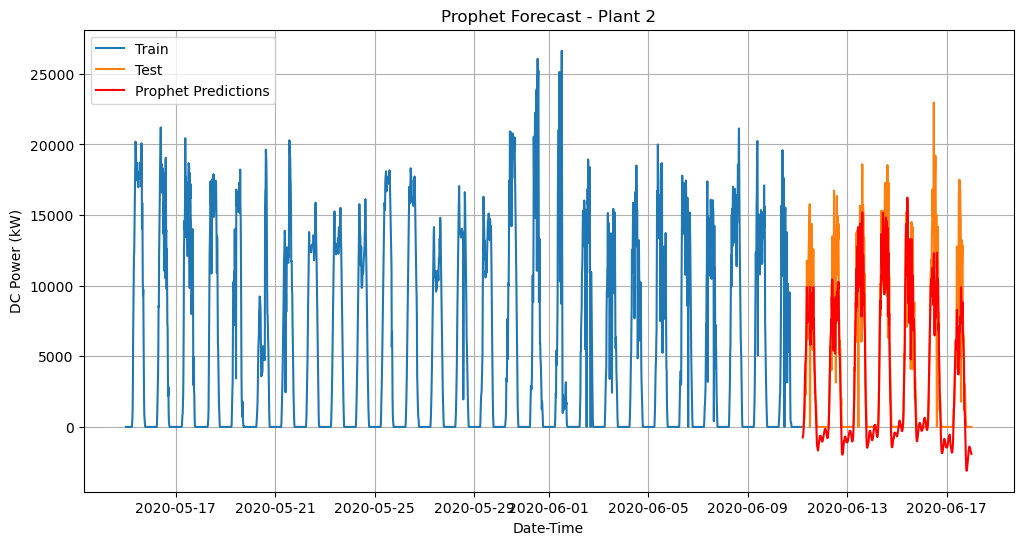

In [70]:
# Prepare data for Prophet
df_prophet = plant2_data[['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE']].reset_index()
df_prophet = df_prophet.rename(columns={'DATE_TIME': 'ds', 'DC_POWER': 'y'})
df_prophet = df_prophet.dropna()

# Temporal split
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

# Fit Prophet
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.add_regressor('IRRADIATION')
model.add_regressor('AMBIENT_TEMPERATURE')
model.fit(train_prophet[['ds', 'y', 'IRRADIATION', 'AMBIENT_TEMPERATURE']])

# Create future dataframe
future = test_prophet[['ds', 'IRRADIATION', 'AMBIENT_TEMPERATURE']]
forecast = model.predict(future)

# Evaluate
predictions = forecast['yhat']
y_test = test_prophet['y']
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Prophet - Plant 2')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test')
plt.plot(test_prophet['ds'], predictions, label='Prophet Predictions', color='red')
plt.title('Prophet Forecast - Plant 2')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **LSTM**

Epoch 1/30
36/36 [==============================] - 11s 148ms/step - loss: 0.0501 - val_loss: 0.0177
Epoch 2/30
36/36 [==============================] - 5s 126ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 3/30
36/36 [==============================] - 5s 126ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 4/30
36/36 [==============================] - 4s 125ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 5/30
36/36 [==============================] - 5s 125ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 6/30
36/36 [==============================] - 5s 128ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 7/30
36/36 [==============================] - 4s 124ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 8/30
36/36 [==============================] - 4s 123ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 9/30
36/36 [==============================] - 5s 125ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 10/30
36/36 [==============================] - 5s 125ms/step - loss: 0.0053 - val_loss: 0.006

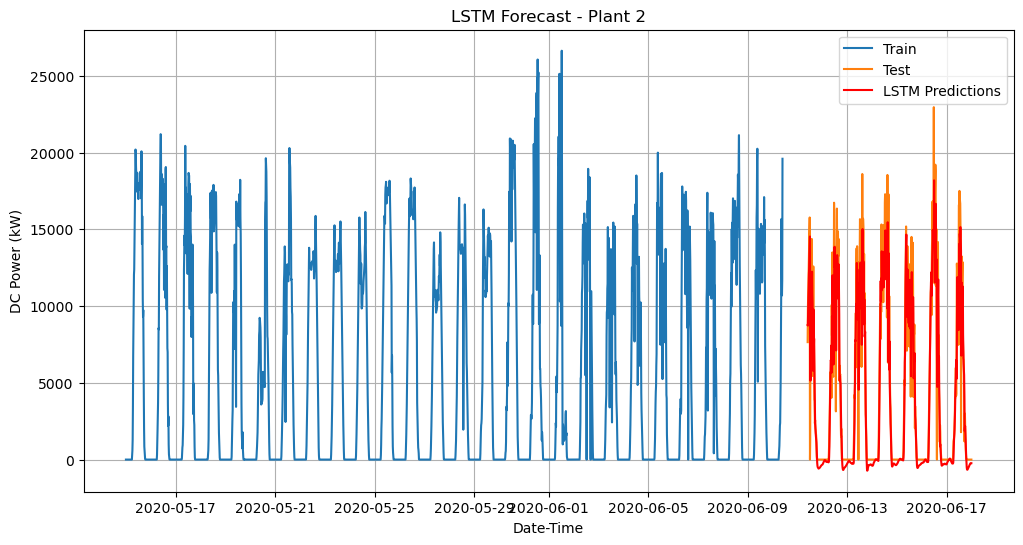

In [75]:
# Prepare data
data = plant2_data[['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict DC_POWER
    return np.array(X), np.array(y)

seq_length = 96  # 1 day
X, y = create_sequences(scaled_data, seq_length)

# Temporal split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

# Predict
predictions = model.predict(X_test)

# Inverse transform predictions
predictions_full = np.zeros((len(predictions), scaled_data.shape[1]))
predictions_full[:, 0] = predictions.flatten()
predictions_full = scaler.inverse_transform(predictions_full)
y_test_full = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_full[:, 0] = y_test
y_test_full = scaler.inverse_transform(y_test_full)

# Evaluate
mse = mean_squared_error(y_test_full[:, 0], predictions_full[:, 0])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_full[:, 0], predictions_full[:, 0])
r2 = r2_score(y_test_full[:, 0], predictions_full[:, 0])

print(f'LSTM - Plant 2')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Plot (approximate index for plotting)
test_indices = data.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], data['DC_POWER'][:train_size], label='Train')
plt.plot(test_indices, y_test_full[:, 0], label='Test')
plt.plot(test_indices, predictions_full[:, 0], label='LSTM Predictions', color='red')
plt.title('LSTM Forecast - Plant 2')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# **Anomaly Detection**

Anomalies detected in Plant 2:
                         DC_POWER  IRRADIATION  AMBIENT_TEMPERATURE  \
DATE_TIME                                                             
2020-05-15 13:00:00  17838.133333     0.926438            36.458581   
2020-05-16 11:30:00  18292.120000     0.981039            34.830906   
2020-05-16 11:45:00  17485.090952     0.989619            35.478209   
2020-05-16 12:00:00  16119.827143     0.979794            36.231302   
2020-05-23 17:00:00   6008.685714     0.224096            38.685983   
2020-05-23 17:15:00   4623.875714     0.174207            38.213572   
2020-05-23 17:30:00   3336.122381     0.128514            37.208696   
2020-05-24 17:00:00   5576.665238     0.220942            38.564861   
2020-05-24 17:15:00   4233.003333     0.170969            38.470519   
2020-05-24 17:30:00   3085.905714     0.124878            39.181638   
2020-05-24 17:45:00   2097.506667     0.085381            37.964523   
2020-05-24 18:00:00   1264.093333     0.051448

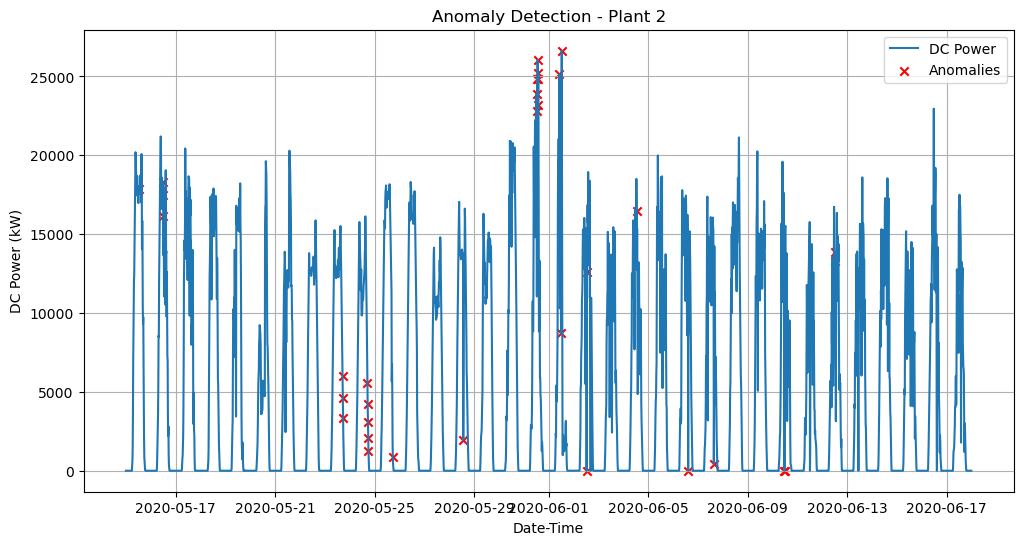

In [76]:
# Prepare data
features = ['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
X = plant2_data[features].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
plant2_data['anomaly'] = iso_forest.fit_predict(X)

# Extract anomalies
anomalies = plant2_data[plant2_data['anomaly'] == -1]
print(f"Anomalies detected in Plant 2:\n{anomalies[features]}")

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(plant2_data.index, plant2_data['DC_POWER'], label='DC Power')
plt.scatter(anomalies.index, anomalies['DC_POWER'], color='red', label='Anomalies', marker='x')
plt.title('Anomaly Detection - Plant 2')
plt.xlabel('Date-Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()